In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as  nn
import matplotlib.pyplot as plt
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

from torch.utils.data import Dataset
from torchvision.datasets import EMNIST
from torchvision.utils import save_image
import albumentations
import albumentations.pytorch
from PIL import Image
import time



In [3]:
# train_transforms = transforms.Compose([
#       transforms.Resize((28,28)),
#       transforms.ToTensor(),
#       transforms.Lambda(lambda x: torchvision.transforms.functional.invert(x)),
#       transforms.Normalize((0, 0, 0), (1, 1, 1)),
#       transforms.Grayscale(num_output_channels=1)
# ])

# test_transforms = transforms.Compose([
#       transforms.Resize((28,28)),
#       transforms.RandomRotation(degrees=45),
#       transforms.Resize((28,28)),
#       transforms.RandomRotation(degrees = 45),
#       transforms.RandomHorizontalFlip(p = 0.3),
#       transforms.RandomVerticalFlip(p = 0.4),
#       transforms.ToTensor(),
#       transforms.Lambda(lambda x: torchvision.transforms.functional.invert(x)),
#       transforms.Normalize((0, 0, 0), (1, 1, 1)),
#       transforms.Grayscale(num_output_channels=1)
      
# ])

In [4]:
train_dataset = EMNIST(root="data/", split="letters", download=True, train=True, 
                transform=transforms.Compose([
                    lambda img: transforms.functional.rotate(img, -90),
                    lambda img: transforms.functional.hflip(img),
                    transforms.ToTensor()
                ]))
                
test_dataset = EMNIST(root="data/", split="letters", download=True, train=False, 
                transform=transforms.Compose([
                                           
                    lambda img: transforms.functional.rotate(img, -90),
                    lambda img: transforms.functional.hflip(img),
                    transforms.ToTensor()
                ]))

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [5]:
# train_dataset_emojis = torchvision.datasets.ImageFolder(root = train_dataset_path_emojis ,transform = train_transforms)
# test_dataset_emojis = torchvision.datasets.ImageFolder(root = test_dataset_path_emojis,transform =test_transforms)


In [6]:
# print(train_dataset_emojis)
print(train_dataset)


Dataset EMNIST
    Number of datapoints: 124800
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               <function <lambda> at 0x7ff82a360cb0>
               <function <lambda> at 0x7ff82a360ef0>
               ToTensor()
           )


In [7]:
print("Total No of Images in EMNIST dataset:", len(train_dataset) + len(test_dataset))
print("No of images in Training dataset:    ",len(train_dataset))
print("No of images in Testing dataset:     ",len(test_dataset))
l = train_dataset.classes
l.sort()
print("No of classes: ",len(l))
print("List of all classes")
print(l)
# classes = train_dataset_emojis.classes
# print(classes)

Total No of Images in EMNIST dataset: 145600
No of images in Training dataset:     124800
No of images in Testing dataset:      20800
No of classes:  27
List of all classes
['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
# This helper funcation convert the output index [0-61] into character [0-9],[A-Z],[a-z]

def to_char(num):
    if num<10:
        return str(num)
    elif num < 36:
        return chr(num+55)
    else:
        return chr(num+61)


# This is reverse of above function. Convert character [0-9],[A-Z],[a-z] into index [0-61]
def to_index(char):
    if ord(char)<59:
        return ord(char)-48
    elif ord(char)<95:
        return ord(char)-55
    else:
        return ord(char)-61


def show_transformed_images(dataset):
  loader = torch.utils.data.DataLoader(dataset,batch_size = 7 , shuffle = True)
  batch  = next(iter(loader))
  images, labels =batch

  grid = torchvision.utils.make_grid(images,nrow = 1)
  plt.figure(figsize = (11,11) )
  plt.imshow(np.transpose(grid,(1,2,0)))
  print('labels: ',labels+1)

In [9]:
# train_dataset_emojis = torchvision.datasets.ImageFolder(root = train_dataset_path_emojis ,transform = train_transforms)

# show_transformed_images(train_dataset_emojis)

labels:  tensor([17, 18, 11, 19, 24, 26, 20, 26,  2, 20, 11, 17, 19,  9, 11, 15, 19,  9,
        13, 15, 26, 20,  2, 15,  2,  2, 13, 25])


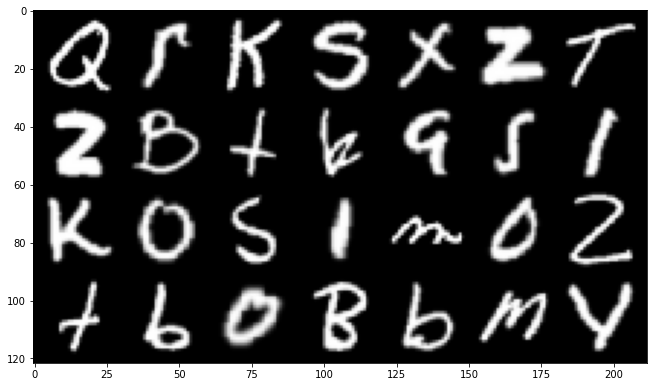

In [10]:
def show_example(data):
    loader = torch.utils.data.DataLoader(data,batch_size = 28 , shuffle = True)
    batch  = next(iter(loader))
    images, labels =batch

    grid = torchvision.utils.make_grid(images,nrow = 7)
    plt.figure(figsize = (11,11) )
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels: ',labels)
show_example(train_dataset)

In [11]:
batch_size = 10
batch_size1 = 7 
# # train_loader1 = torch.utils.data.DataLoader(train_dataset_emojis, batch_size=batch_size1,
#                                           shuffle=True)
# test_loader1 = torch.utils.data.DataLoader(test_dataset_emojis, batch_size=batch_size1,
#                                           shuffle=False)


# classes = ('1','2','3','4','5','6','7')

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [13]:
# set the device on which the model will be trained
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
#### end code here ####
print(device)

cuda:0


In [127]:
#letters

class CNNModel(nn.Module):
      def __init__(self):
          super(CNNModel,self).__init__()

          #Convolution :
          self.cnn1 = nn.Conv2d(in_channels = 1 ,out_channels = 16 , kernel_size = 3, stride = 1 , padding = 0)
          self.relu1 = nn.ReLU()
          self.maxpool1 = nn.MaxPool2d(kernel_size = (2,2))

          #Convolution 2
          self.cnn2 = nn.Conv2d(in_channels = 16 ,out_channels = 32 , kernel_size = 3, stride = 1 , padding = 0)
          self.relu2 = nn.ReLU()
          self.maxpool2 = nn.MaxPool2d(kernel_size =2 )
          #Linear
          self.fc1 = nn.Linear(in_features=800, out_features=500)
          
          self.relu3 = nn.ReLU()

          self.fc2 = nn.Linear(500,27) 
          # self.soft = nn.LogSoftmax(dim=1)     
          
      def forward(self,x):
          out = self.cnn1(x)
          out = self.relu1(out)
          out = self.maxpool1(out)

          out = self.cnn2(out)
          out = self.relu2(out)
          out = self.maxpool2(out)

          out = out.view(out.size(0),-1)

          out = self.fc1(out)
          out = self.relu3(out)

          out = self.fc2(out)
          # out = self.soft(out)

          return out
          


In [128]:
model = CNNModel().to(device)
model


CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=27, bias=True)
  (soft): LogSoftmax(dim=1)
)

In [129]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("number of parameters/weights ", pytorch_total_params)

number of parameters/weights  418827


In [130]:
# Optimizer
#### start code here ####
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#### end code here ####

In [131]:
#emojis

# class CNNModel1(nn.Module):
#       def __init__(self):
#           super(CNNModel1,self).__init__()

#           #Convolution :
#           self.cnn1 = nn.Conv2d(in_channels = 1 ,out_channels = 16 , kernel_size = 3, stride = 1 , padding = 0)
#           self.relu1 = nn.ReLU()
#           self.maxpool1 = nn.MaxPool2d(kernel_size = (2,2))

#           #Convolution 2
#           self.cnn2 = nn.Conv2d(in_channels = 16 ,out_channels = 32 , kernel_size = 3, stride = 1 , padding = 0)
#           self.relu2 = nn.ReLU()
#           self.maxpool2 = nn.MaxPool2d(kernel_size =2 )

#           self.fc1 = nn.Linear(in_features=800, out_features=500)
#           self.relu3 = nn.ReLU()

#           self.fc2 = nn.Linear(500,7)          
          
#       def forward(self,x):
#           out = self.cnn1(x)
#           out = self.relu1(out)
#           out = self.maxpool1(out)

#           out = self.cnn2(out)
#           out = self.relu2(out)
#           out = self.maxpool2(out)

#           out = out.view(out.size(0),-1)

#           out = self.fc1(out)
#           out = self.relu3(out)

#           out = self.fc2(out)

#           return out
          


In [132]:
# model1 = CNNModel1().to(device)
# model1

In [133]:
# pytorch_total_params1 = sum(p.numel() for p in model1.parameters() if p.requires_grad)
# print("number of parameters/weights ", pytorch_total_params1)

In [134]:
# learning_rate = 0.01
# optimizer1 = torch.optim.SGD(model1.parameters(), lr=learning_rate)
#### end code here ####

In [137]:
# Cross Entropy Loss 
#### start code here ####
error = nn.CrossEntropyLoss() #loss
#### end code here ####

In [138]:
#for letters

num_epochs = 10

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = error(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i) % 10000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')

Epoch [1/10], Step [1/12480], Loss: 3.2819
Epoch [1/10], Step [10001/12480], Loss: 1.2490
Epoch [2/10], Step [1/12480], Loss: 0.2353
Epoch [2/10], Step [10001/12480], Loss: 0.6816
Epoch [3/10], Step [1/12480], Loss: 0.1933
Epoch [3/10], Step [10001/12480], Loss: 0.1135
Epoch [4/10], Step [1/12480], Loss: 0.0323
Epoch [4/10], Step [10001/12480], Loss: 0.0415
Epoch [5/10], Step [1/12480], Loss: 0.0285
Epoch [5/10], Step [10001/12480], Loss: 0.0119
Epoch [6/10], Step [1/12480], Loss: 0.0644
Epoch [6/10], Step [10001/12480], Loss: 0.0102
Epoch [7/10], Step [1/12480], Loss: 0.2536
Epoch [7/10], Step [10001/12480], Loss: 0.0016
Epoch [8/10], Step [1/12480], Loss: 0.1785
Epoch [8/10], Step [10001/12480], Loss: 0.0482
Epoch [9/10], Step [1/12480], Loss: 0.1077
Epoch [9/10], Step [10001/12480], Loss: 0.0399
Epoch [10/10], Step [1/12480], Loss: 0.0043
Epoch [10/10], Step [10001/12480], Loss: 0.0164
Finished Training


In [29]:
PATH = '/content/drive/MyDrive/MOSAIC_PS1/letters.h5'
torch.save(model.state_dict(), PATH)

In [140]:
#for letters
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(27)]
    n_class_samples = [0 for i in range(27)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        # print(labels)
        # print('\n')
        # print(predicted)
        # print(predicted.sum())
        # print(predicted.sum().item())
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the letters {acc} %')

    for i in range(27):
        acc=0
        if(n_class_samples[i] != 0): acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {l[i]}: {acc} %')

Accuracy of the letters 93.10576923076923 %
Accuracy of N/A: 0 %
Accuracy of a: 90.375 %
Accuracy of b: 96.125 %
Accuracy of c: 95.125 %
Accuracy of d: 93.0 %
Accuracy of e: 97.125 %
Accuracy of f: 96.5 %
Accuracy of g: 72.625 %
Accuracy of h: 93.875 %
Accuracy of i: 75.375 %
Accuracy of j: 95.125 %
Accuracy of k: 96.5 %
Accuracy of l: 72.625 %
Accuracy of m: 98.625 %
Accuracy of n: 96.375 %
Accuracy of o: 98.625 %
Accuracy of p: 98.0 %
Accuracy of q: 92.875 %
Accuracy of r: 95.25 %
Accuracy of s: 97.5 %
Accuracy of t: 96.125 %
Accuracy of u: 95.0 %
Accuracy of v: 92.5 %
Accuracy of w: 97.375 %
Accuracy of x: 95.375 %
Accuracy of y: 95.25 %
Accuracy of z: 97.5 %


In [159]:
def segmentCaptcha(img):
  img = cv2.resize(img, (800,300), interpolation = cv2.INTER_AREA)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  _, th1 = cv2.threshold(img_gray,190, 255, cv2.THRESH_BINARY_INV)
  kernel = np.ones((5,5), dtype = np.uint8)
  img_dil = cv2.dilate(th1, kernel, iterations=2)

  contours, _ = cv2.findContours(img_dil, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  
  sorted_ctrs = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
  img_crops = []
  k=0
  for i, ctr in enumerate(sorted_ctrs):
      x, y, w, h = cv2.boundingRect(ctr)

      
      # plt.imshow(rect, cmap="gray")
      if w*h>1600:
        crop_img = th1[y:y+h, x:x+w]
        
        rect = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        crop_img = cv2.resize(crop_img, (28, 28), interpolation = cv2.INTER_AREA)
        k+=1
        img_crops.append(crop_img)

  return img_crops, rect

In [185]:
img = cv2.imread('/content/drive/MyDrive/MOSAIC_PS1/Lawda2.jpeg')
img_crops, rect = segmentCaptcha(img)


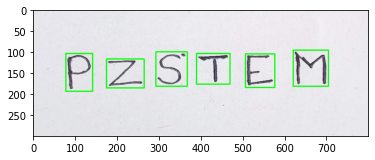

In [186]:
plt.imshow(rect, cmap = 'gray')
plt.show()

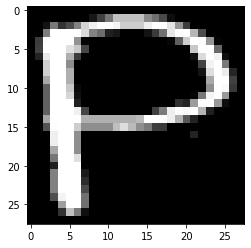

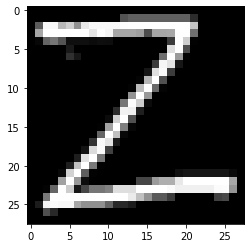

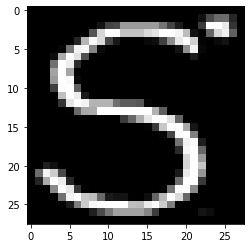

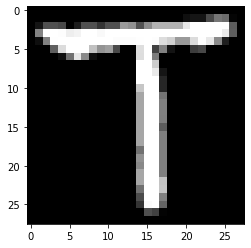

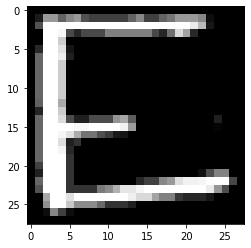

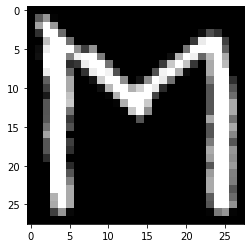

In [187]:

for img in img_crops:
  plt.imshow(img, cmap = 'gray')
  plt.show()

In [188]:
img_crops = np.array(img_crops)
img_crops = torch.Tensor(img_crops)

In [189]:
inputs  = img_crops
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# inputs= inputs.to(device)


In [190]:
letter_model = CNNModel()

In [191]:
letter_model.load_state_dict(torch.load('/content/drive/MyDrive/MOSAIC_PS1/letters.h5'))

<All keys matched successfully>

In [192]:
letter_model.eval()

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=27, bias=True)
  (soft): LogSoftmax(dim=1)
)

In [193]:
# print(images[0].shape)
# len(test_loader1)

In [194]:
# inputs1=inputs1.unsqueeze(0)
# inputs1=inputs1.unsqueeze(0)
# # inputs1 = inputs1.cuda()
# # torch.reshape(inputs1,(1,1,28,28))
# print(inputs1.shape)

In [195]:
with torch.no_grad():
  for inputs1 in inputs:
    inputs1=inputs1.unsqueeze(0)
    inputs1=inputs1.unsqueeze(0)
    outp = letter_model(inputs1)
    outp = torch.squeeze(outp)
    outp = torch.softmax(outp,dim= 0)
    # print(outp)
    pr = torch.argmax(outp)
    captcha = l[pr]
    captcha = captcha.capitalize()
    print(captcha, end="")
    # outp1= emoji_model(inputs1)
    # _, pred1 = torch.max(outp1,1)
    # print(classes[pred1.item()])

PZSTEM